# AutoEndcoder

## 1) Download Datasets

In [1]:
from torchvision import datasets
from torchvision import transforms

train_data = datasets.FashionMNIST(root="data", train=True, download=True, transform=transforms.ToTensor())
test_data = datasets.FashionMNIST(root="data", train=False, download=True, transform=transforms.ToTensor())

len(train_data), len(test_data)


100%|██████████| 26.4M/26.4M [00:32<00:00, 808kB/s] 


Extracting data\FashionMNIST\raw\train-images-idx3-ubyte.gz to data\FashionMNIST\raw



100%|██████████| 29.5k/29.5k [00:00<00:00, 185kB/s]


Extracting data\FashionMNIST\raw\train-labels-idx1-ubyte.gz to data\FashionMNIST\raw



100%|██████████| 4.42M/4.42M [00:04<00:00, 1.00MB/s]


Extracting data\FashionMNIST\raw\t10k-images-idx3-ubyte.gz to data\FashionMNIST\raw



100%|██████████| 5.15k/5.15k [00:00<?, ?B/s]

Extracting data\FashionMNIST\raw\t10k-labels-idx1-ubyte.gz to data\FashionMNIST\raw



(60000, 10000)

## 2) Visualize datasets

In [2]:
class_names = train_data.classes

Shape of Img torch.Size([1, 28, 28])


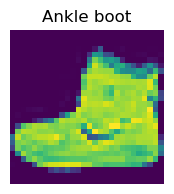

In [3]:
import matplotlib.pyplot as plt
for img, label in train_data:
    print(f"Shape of Img", img.shape)
    plt.figure(figsize=(2,2))
    plt.imshow(img.squeeze())
    plt.title(class_names[label])
    plt.axis(False)
    plt.savefig("filename.png")
    break

## 3) DataLoader

In [4]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(dataset=train_data, batch_size=32, shuffle=True)
test_dataloader = DataLoader(dataset=test_data, batch_size=32, shuffle=False)

In [5]:
len(train_dataloader), len(test_dataloader)

(1875, 313)

In [6]:
for batch_idx, (img, label) in enumerate(train_dataloader):
    print(f"Batch indx {batch_idx} Images shape {img.shape} label shapoe {label.shape}")
    break


Batch indx 0 Images shape torch.Size([32, 1, 28, 28]) label shapoe torch.Size([32])


## 4) Build a Model

In [7]:
import torch.nn as nn

class AutoEncoder(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.encode = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=input_dim, out_features=256),
            nn.ReLU(),
            nn.Linear(in_features=256, out_features=64),
            nn.ReLU(),
            nn.Linear(in_features=64, out_features=16),
            nn.ReLU()
        )
        self.decode = nn.Sequential(
            nn.Linear(in_features=16, out_features=64),
            nn.ReLU(),
            nn.Linear(in_features=64, out_features=256),
            nn.ReLU(),
            nn.Linear(in_features=256, out_features=input_dim),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encode(x)
        x = self.decode(x)
        return x


In [8]:
import torch
dummy_image = torch.rand((32,1,28,28))

In [9]:
model = AutoEncoder(28*28)
# model(dummy_image)

In [10]:
from torchinfo import summary

summary(model, input_size=(32,1,28,28))

Layer (type:depth-idx)                   Output Shape              Param #
AutoEncoder                              [32, 784]                 --
├─Sequential: 1-1                        [32, 16]                  --
│    └─Flatten: 2-1                      [32, 784]                 --
│    └─Linear: 2-2                       [32, 256]                 200,960
│    └─ReLU: 2-3                         [32, 256]                 --
│    └─Linear: 2-4                       [32, 64]                  16,448
│    └─ReLU: 2-5                         [32, 64]                  --
│    └─Linear: 2-6                       [32, 16]                  1,040
│    └─ReLU: 2-7                         [32, 16]                  --
├─Sequential: 1-2                        [32, 784]                 --
│    └─Linear: 2-8                       [32, 64]                  1,088
│    └─ReLU: 2-9                         [32, 64]                  --
│    └─Linear: 2-10                      [32, 256]                 16,

## 5) Loss function and optimxer

In [11]:
# loss_fn = nn.CrossEntropyLoss()
# since output is an image itself aso use mseloss
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)

## 6) Train Loop

In [12]:
from tqdm.auto import tqdm
epochs = 10
for epoch in tqdm(range(epochs)):
    train_loss = 0
    model.train()
    for img, label in tqdm(train_dataloader, leave=False):
        img = img.flatten(start_dim=1)
        # print(img.shape)
        y_pred = model(img)
        loss = loss_fn(y_pred, img)
        train_loss += loss

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    train_loss /= len(train_dataloader)
    print(f"Loss: {loss.item():.4f}")


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1875 [00:00<?, ?it/s]

Loss: 0.0183


  0%|          | 0/1875 [00:00<?, ?it/s]

Loss: 0.0140


  0%|          | 0/1875 [00:00<?, ?it/s]

Loss: 0.0147


  0%|          | 0/1875 [00:00<?, ?it/s]

Loss: 0.0145


  0%|          | 0/1875 [00:00<?, ?it/s]

Loss: 0.0135


  0%|          | 0/1875 [00:00<?, ?it/s]

Loss: 0.0123


  0%|          | 0/1875 [00:00<?, ?it/s]

Loss: 0.0115


  0%|          | 0/1875 [00:00<?, ?it/s]

Loss: 0.0134


  0%|          | 0/1875 [00:00<?, ?it/s]

Loss: 0.0125


  0%|          | 0/1875 [00:00<?, ?it/s]

Loss: 0.0135


## 7) Test Loop

In [13]:
model.eval()
test_loss = 0
with torch.no_grad():  # No gradients needed during evaluation
    for img, _ in tqdm(test_dataloader, leave=False):
        img = img.flatten(start_dim=1) # Flatten images
        y_pred = model(img)
        loss = loss_fn(y_pred, img)  # Compare with original input
        test_loss += loss.item()

test_loss /= len(test_dataloader)
print(f"Test Loss: {test_loss:.4f}")

  0%|          | 0/313 [00:00<?, ?it/s]

Test Loss: 0.0120


## 8) Visualize image

--------------


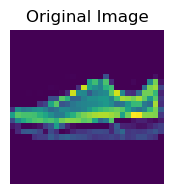

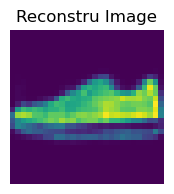

--------------


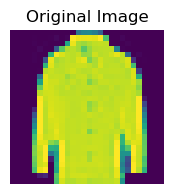

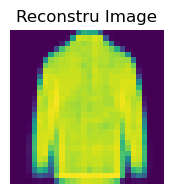

--------------


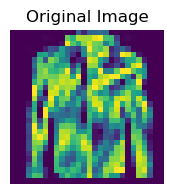

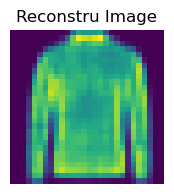

--------------


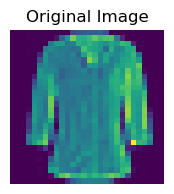

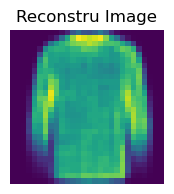

--------------


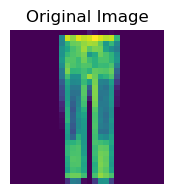

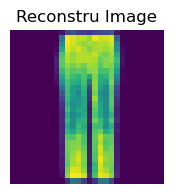

--------------


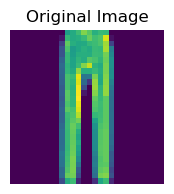

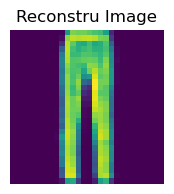

In [14]:
img, label = next(iter(test_dataloader))
img = img.flatten(start_dim=1)

# Pass through the model
with torch.no_grad():
    reconstructed = model(img)

img = img.view(-1, 1, 28, 28)
reconstructed = reconstructed.view(-1, 1, 28, 28)

for i in range(6):
    print("--------------")
    random_idx = torch.randint(0,32,size=[1])
    getorgimg = img[random_idx]
    getreimg = reconstructed[random_idx]

    plt.figure(figsize=(2,2))
    plt.imshow(getorgimg.squeeze())
    plt.title("Original Image")
    plt.axis("off")
    plt.show()

    plt.figure(figsize=(2,2))
    plt.imshow(getreimg.squeeze())
    plt.title("Reconstru Image")
    plt.axis("off")
    plt.show()
